In [1]:
%pylab inline
from astropy import units
import astropy as apy
from profiles import *
from math import erf
from cosmotools import *

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:758: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now '/home/ngaravito/.config'/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
rho = dens_NFW(11, 10, 0, 0, 1E12) # a, r, v


In [3]:
def df(rps, vmv, M_sat):
    rho = dens_sis(10, 50, vmv)
    vmv = vmv * units.km / units.s
    vmv = vmv.to(units.kpc / units.s)
    M_sat = M_sat * units.Msun
    rps = rps * units.kpc
    G = apy.constants.G
    G = G.to(units.kpc**3 / units.Msun / units.s**2)
    factor = - 4 * np.pi * G**2  
    bmax = rps # Radial position of satellite at any given time
    k = 3 * units.kpc # kpc
    bmin = 1.6 * k
    L = bmax / bmin
    Coulomb = log(L)
    print Coulomb
    sigma = vmv / np.sqrt(2)
    X = vmv / ( np.sqrt(2) * sigma )
    F_df = factor * M_sat * rho * Coulomb / vmv**3 * (  erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))  ) * vmv
    return F_df

In [4]:
df(50, 100, 1E11)

2.34340708751


<Quantity 9.059363484328157e-31 kpc / s2>

In [65]:
def coulomb_log(r):
    bmax = r # position of test particle at a time t
    k = 3 * units.kpc # kpc
    bmin = 1.6 * k # k is the softening length if the LMC were modeled using a plummer progile . See Besla07
    L = bmax / bmin
    return np.log(L)

def sigma(c, r, M_halo):
    M_halo = M_halo * units.Msun
    Rvir = rvir(M_halo.value, 0) 
    vvir = np.sqrt( G * M_halo / Rvir) 
    g = log(1+c) - (c /(1+c))
    vmax = np.sqrt(0.216 * vvir**2 * c / g)
    rs = Rvir / c
    x = r / rs
    sigma = vmax * 1.4393 * x **(0.354) / (1 + 1.1756*x**0.725)
    sigma = sigma.to(units.kpc / units.Gyr)
    return sigma

sigma(11, 10 * units.kpc, 1E12)

def dynamical_friction_sis(x, y, z, vx, vy, vz, M_sat):
    x = x * units.kpc
    y = y * units.kpc
    z = z * units.kpc
    r = np.sqrt(x**2 + y**2 + z**2)
    vx = vx * units.kpc / units.Gyr
    vy = vy * units.kpc / units.Gyr
    vz = vz * units.kpc / units.Gyr
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    rho = dens_NFW(11, x.value, y.value, z.value, 1E12) # a, r, v
    M_sat = M_sat * units.Msun
    factor = 4 * np.pi * G**2
    #print G
    Coulomb = coulomb_log(r)
    #print Coulomb
    s = sigma(11, r, 1E12)
    X = v / ( np.sqrt(2) * s ) 
    F_dfx = factor * M_sat * rho * Coulomb / v**3 * (  erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))  ) * vx
    F_dfy = factor * M_sat * rho * Coulomb / v**3 * (  erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))  ) * vy
    F_dfz = factor * M_sat * rho * Coulomb / v**3 * (  erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))  ) * vz
    F_dfx = F_dfx.to(units.kpc / units.Gyr**2)
    F_dfy = F_dfy.to(units.kpc / units.Gyr**2)
    F_dfz = F_dfz.to(units.kpc / units.Gyr**2)
    tt = factor * M_sat * rho * Coulomb / v**3 * vy
    print tt.to(units.kpc / units.Gyr**2)
    print erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))
    return F_dfx.value, F_dfy.value/10, F_dfz.value


In [75]:
dynamical_friction_sis(1, 0, 0, 0, 158, 0, 1E11)
sigma(10)

-205707.778258 kpc / Gyr2
-179.879420818


TypeError: sigma() takes exactly 3 arguments (1 given)

In [76]:
def acceleration(x, y, z, vx, vy, vz):
    M_bulge = 1E10
    M_disk = 5.5E10
    M_halo = 1E12
    M_sat = 1E11
    #asis = a_sis(10, x, y, z, 200)
    #adisk = a_mn(6.5, 0.6, x, y, z, M_disk)
    ahalo = a_NFW(11.0, x, y, z, M_halo)
    #print abulge, adisk, ahalo
    ax = ahalo[0] #+ adisk[0] + ahalo[0]
    ay = ahalo[1] #+ adisk[1] + ahalo[1]
    az = ahalo[2] #+ adisk[2] + ahalo[2]
    ax = ax.to(units.kpc/units.Gyr**2)  
    ay = ay.to(units.kpc/units.Gyr**2) 
    az = az.to(units.kpc/units.Gyr**2) 
    F_dfx, F_dfy, F_dfz = dynamical_friction_sis(x, y, z, vx, vy, vz, M_sat)
    Ax = ax.value + F_dfx
    Ay = ay.value + F_dfy
    Az = az.value + F_dfz
    return Ax, Ay, Az

In [77]:
acceleration(10, 0, 0, 0, 150, 0)

5757.82936615 kpc / Gyr2
-6.34325541005


(-2459.7019928968857, -3652.3382276947623, -0.0)

In [78]:
def leapfrog(n_points, h, x_ic, y_ic, z_ic, vx_ic, vy_ic, vz_ic):

        #n_points = 3000
        #h = 0.001
        # Creating the arrays to collect the data in each step of the integration
        # the imput units should be in Kpc and Gyrs!

        t = np.zeros(n_points)
        x = np.zeros(n_points)
        y = np.zeros(n_points)
        z = np.zeros(n_points)

        vx = np.zeros(n_points)
        vy = np.zeros(n_points)
        vz = np.zeros(n_points)


        ax = np.zeros(n_points)
        ay = np.zeros(n_points)
        az = np.zeros(n_points)

        t[0] = 0

        # This initial conditions come form MW.py, the units are Kpc and Gyr
        x[0] = x_ic
        y[0] = y_ic
        z[0] = z_ic


        vx[0] = vx_ic
        vy[0] = vy_ic
        vz[0] = vz_ic

        ax[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[0]
        ay[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[1]
        az[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[2]

        # one half step 

        t[1] = t[0] + h
        x[1] = x[0] + h * vx[0]
        y[1] = y[0] + h * vy[0]
        z[1] = z[0] + h * vz[0]

        vx[1] = vx[0] + h*acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[0]
        vy[1] = vy[0] + h*acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[1]
        vz[1] = vz[0] + h*acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[2]

        ax[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[0]
        ay[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[1]
        az[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[2]

        # iterate over all the steps!

        for i in range(2,n_points):
            t[i] = t[i-1] + h

            x[i] = x[i-2] + 2 * h * vx[i-1]
            y[i] = y[i-2] + 2 * h * vy[i-1]
            z[i] = z[i-2] + 2 * h * vz[i-1]

            vx[i] = vx[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[0]
            vy[i] = vy[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[1]
            vz[i] = vz[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[2]
        
        return x, y, z, t 

In [79]:
X, Y, Z, t = leapfrog(200, 0.01, 10, 0, 0, 0, 156.834371006, 0)

5266.94539066 kpc / Gyr2
-7.90290055413
5266.94539066 kpc / Gyr2
-7.90290055413
5266.94539066 kpc / Gyr2
-7.90290055413
5266.94539066 kpc / Gyr2
-7.90290055413
5266.94539066 kpc / Gyr2
-7.90290055413
5266.94539066 kpc / Gyr2
-7.90290055413
9102.21868421 kpc / Gyr2
-2.2174085295
9102.21868421 kpc / Gyr2
-2.2174085295
9102.21868421 kpc / Gyr2
-2.2174085295
9102.21868421 kpc / Gyr2
-2.2174085295
9102.21868421 kpc / Gyr2
-2.2174085295
9102.21868421 kpc / Gyr2
-2.2174085295
9252.09461279 kpc / Gyr2
-2.05617706976
9252.09461279 kpc / Gyr2
-2.05617706976
9252.09461279 kpc / Gyr2
-2.05617706976
811.802004632 kpc / Gyr2
-53.3058142069
811.802004632 kpc / Gyr2
-53.3058142069
811.802004632 kpc / Gyr2
-53.3058142069
0.0364571112068 kpc / Gyr2
-9.44447958921e+250
0.0364571112068 kpc / Gyr2
-9.44447958921e+250
0.0364571112068 kpc / Gyr2
-9.44447958921e+250
-0.0 kpc / Gyr2
-inf
-0.0 kpc / Gyr2
-inf
-0.0 kpc / Gyr2
-inf
nan kpc / Gyr2
nan
nan kpc / Gyr2
nan
nan kpc / Gyr2
nan
nan kpc / Gyr2
nan
nan kp

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in square
profiles.py:285: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:785: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: overflow encountered in square
profiles.py:247: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)


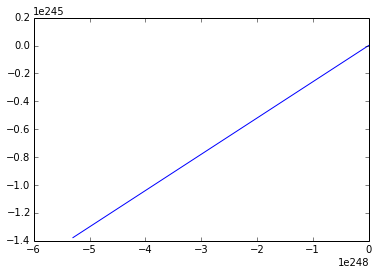

In [80]:
plot(X, Y)

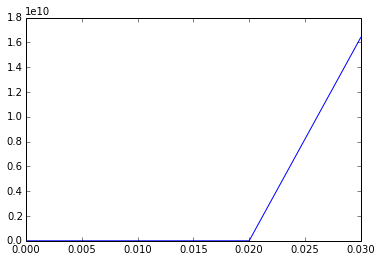

In [52]:
plot(t, np.sqrt(X**2+Y**2+Z**2))

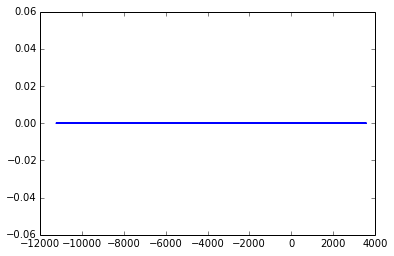

In [48]:
plot(Y, Z)